In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets


/home/sumit/anaconda3/envs/torch_gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mean_gray = 0.1307
stddev_gray = 0.3081

# Convert image to tensor
# input[channel] = (input[channel]-mean[channel])/ std[channel]
transforms = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,),(stddev_gray))])



train_dataset = datasets.MNIST(root = './data',train = True, transform = transforms,download=True)
test_dataset = datasets.MNIST(root = './data',train = False, transform = transforms)


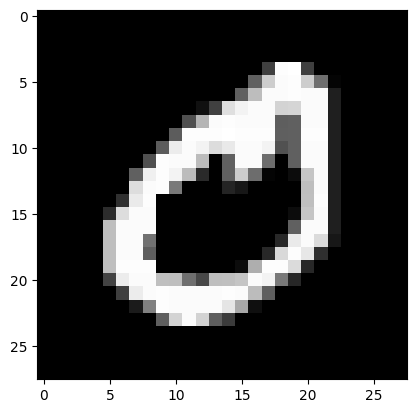

In [3]:
import matplotlib.pyplot as plt
# Denormalize image to visualize it
random_img = train_dataset[21][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28),cmap='gray')

In [4]:
train_dataset[20][1]

4

In [5]:
batch_size = 100
train_load = torch.utils.data.DataLoader(dataset = train_dataset,
                                        batch_size = batch_size,
                                        shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset,
                                       batch_size = batch_size,
                                       shuffle = False)

In [6]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [7]:
print(len(train_load))

600


In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # same padding = (filter_size-1)/2 --> (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3,stride = 1, padding = 1)
        # The output size of each of the 8 features maps
        # [(input_size - filter_size + 2(padding))/stride+1] = (28-3+2)1+1 = 28
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 2)
        # the output size = 28/12 = 14
        # Same padding = (5-1)/2
        self.cnn2 = nn.Conv2d(in_channels = 8, out_channels = 32,kernel_size = 5, stride = 1,padding = 2)
        # Output size of each of 32 feature maps
        #[(input_size - filter_size + 2(padding))/stride +1] 
        # (14 - 5 +4)/1 + 1 = 14
        
        # Flatten the 32 feature maps: 7*7*32 = 1568
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(1568,600)
        self.dropout = nn.Dropout(p = 0.5)
        self.fc2 = nn.Linear(600,10)
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # Flatten the 32 feature maps from max Pool to feed it to the FC1(100,1568)
        out = out.view(-1,1568)
        
        # Forwarding through fully connected layer
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
        

In [9]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [10]:
### Training the CNN
num_epochs = 10
train_loss = []
train_accuracy = []
test_loss1 = []
test_accuracy = []



for epoch in range(num_epochs):
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()
    
    for i,(inputs,labels) in enumerate (train_load):
        
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
            
        outputs = model(inputs)
        
        # calculate loss
        loss = loss_fn(outputs,labels)
        iter_loss += loss.item()
        
        optimizer.zero_grad() # w <-- w - lr*gradient
        loss.backward()
        optimizer.step()
        
        # Maximum of predictions
        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum().item()
        iterations += 1
    
    train_loss.append(iter_loss/iterations)
    train_accuracy.append(100*correct/len(train_dataset))
        
    # Testing phase
    test_loss = 0.0
    correct = 0.0
    iterations = 0.0
    
    model.eval()
    
    
    for i,(inputs,labels) in enumerate(test_load):
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
            
        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        test_loss += loss.item()
        
        _,predicted = torch.max(outputs,1)
        correct += (predicted == labels).sum().item()
        iterations +=1 
        
    test_loss1.append(test_loss/iterations)
    test_accuracy.append((100*correct / len(test_dataset)))
    
    print("Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Accuracy: {:.3f}".format(
    epoch+1,num_epochs,train_loss[-1],train_accuracy[-1],test_loss1[-1],test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.698, Training Accuracy: 79.693, Testing Loss: 0.069, Testing Accuracy: 97.880
Epoch 2/10, Training Loss: 0.183, Training Accuracy: 94.430, Testing Loss: 0.060, Testing Accuracy: 98.230
Epoch 3/10, Training Loss: 0.118, Training Accuracy: 96.622, Testing Loss: 0.037, Testing Accuracy: 98.790
Epoch 4/10, Training Loss: 0.094, Training Accuracy: 97.362, Testing Loss: 0.036, Testing Accuracy: 98.840
Epoch 5/10, Training Loss: 0.080, Training Accuracy: 97.680, Testing Loss: 0.040, Testing Accuracy: 98.890
Epoch 6/10, Training Loss: 0.076, Training Accuracy: 97.752, Testing Loss: 0.053, Testing Accuracy: 98.670
Epoch 7/10, Training Loss: 0.069, Training Accuracy: 98.060, Testing Loss: 0.042, Testing Accuracy: 98.850
Epoch 8/10, Training Loss: 0.059, Training Accuracy: 98.250, Testing Loss: 0.046, Testing Accuracy: 98.790
Epoch 9/10, Training Loss: 0.063, Training Accuracy: 98.212, Testing Loss: 0.053, Testing Accuracy: 98.750
Epoch 10/10, Training Loss: 0.061, Tr

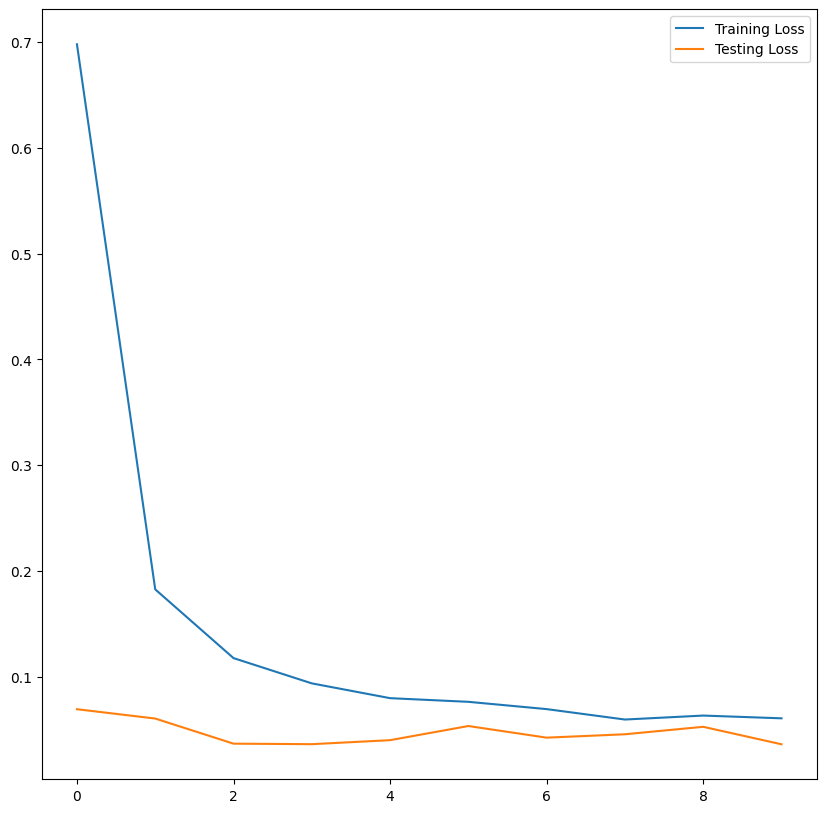

In [19]:
# Plotting the loss
f = plt.figure(figsize=(10,10))
plt.plot(train_loss,label = 'Training Loss')
plt.plot(test_loss1,label = 'Testing Loss')
plt.legend()
plt.show()

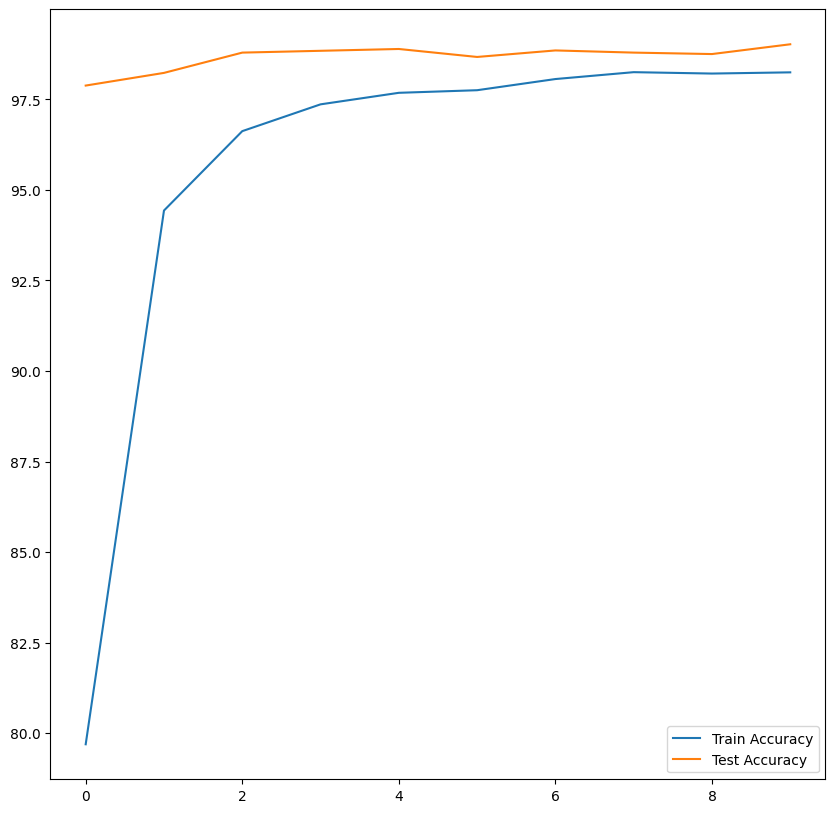

In [18]:
# Plot the accuracy
f = plt.figure(figsize=(10,10))
plt.plot(train_accuracy,label='Train Accuracy')
plt.plot(test_accuracy,label='Test Accuracy')
plt.legend()
plt.show()

In [23]:
img = test_dataset[30][0].resize_(1,1,28,28)
label = test_dataset[30][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()
    
outputs = model(img)
_,predicted = torch.max(outputs,1)
print(f'prediction is {predicted.item()}')
print(f'Actual is : {label}')

prediction is 3
Actual is : 3


In [26]:
#Run this if you want to save the model
torch.save(model.state_dict(),'CNN_MNIST.pth')

#Run this if you want to load the model
model.load_state_dict(torch.load('CNN_MNIST.pth'))

<All keys matched successfully>

In [38]:
import torchvision.transforms as transforms
import cv2
from PIL import Image
from torch.autograd import Variable
transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])


In [39]:
def predict(img_name,model):
    image = cv2.imread(img_name,0)
    ret,thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    img = 255 - thresholded
    cv2.imshow('original',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    img = Image.fromarray(img)
    img = transforms_photo(img)
    img = img.view(1,1,28,28)
    img = Variable(img)
    
    model.eval()
    
    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)
    return  predicted.item()

In [40]:
pred = predict('3.jpg', model)
print("The Predicted Label is {}".format(pred))

tensor([[ 2.1890, -3.4013, -1.1489,  1.6393, -3.7708, -3.8137, -6.1720,  2.6392,
         -2.2378,  0.0137]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 2.1890, -3.4013, -1.1489,  1.6393, -3.7708, -3.8137, -6.1720,  2.6392,
         -2.2378,  0.0137]], device='cuda:0')
The Predicted Label is 7
